In [1]:
import numpy as np
from tensorflow import keras
import pickle as pkl

In [2]:
full_data = pkl.load(open('ASL_FINAL_data.p','rb'))

In [3]:
full_data.shape

(1986, 9, 256, 256, 3)

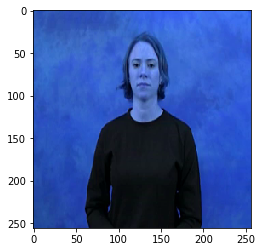

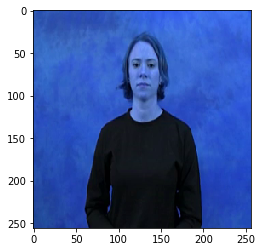

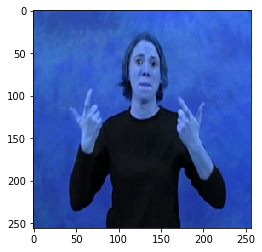

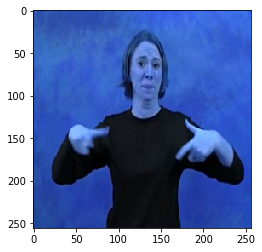

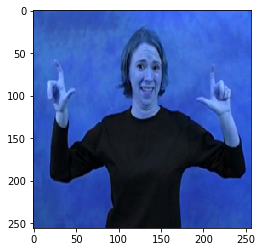

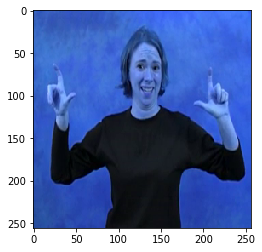

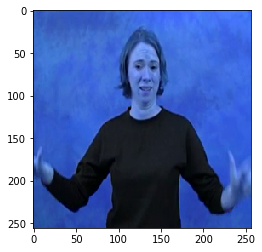

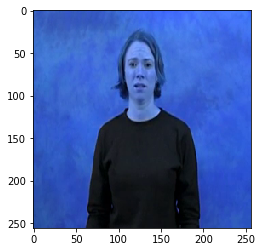

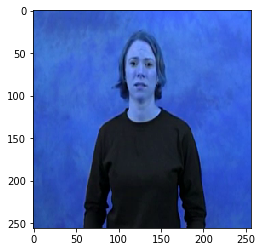

In [4]:
import matplotlib.pyplot as plt

for frame in full_data[0]:
    plt.imshow(frame)
    plt.show()

In [5]:
full_data_labels = pkl.load(open('ASL_FINAL_labels.p','rb'))

In [6]:
full_data_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
full_data_labels.shape

(1986, 14)

In [8]:
for i in range(14):
    print(int(np.sum(full_data_labels[:,i])))

136
156
145
170
168
115
114
79
142
172
150
152
129
158


In [9]:
labels_is_p = full_data_labels[:,7] == 1

In [10]:
np.sum(labels_is_p)

79

In [11]:
labels_is_none = full_data_labels[:,]

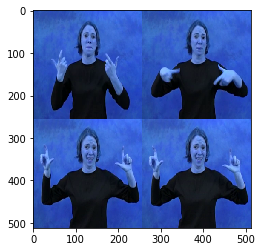

In [12]:
top_row = [np.concatenate((full_data[0][2][i], full_data[0][3][i]),axis=0) for i in range(256)]
# middle_row = [np.concatenate((full_data[0][3][i], full_data[0][4][i], full_data[0][5][i]),axis=0) for i in range(256)]
bottom_row = [np.concatenate((full_data[0][4][i], full_data[0][5][i]),axis=0) for i in range(256)]
word_one = np.concatenate((top_row, bottom_row),axis=0)

plt.imshow(word_one)

In [13]:
merged_frames_data = []
for word in range(len(full_data)):
    top_row = [np.concatenate((full_data[word][2][i], full_data[word][3][i]),axis=0) for i in range(256)]
    bottom_row = [np.concatenate((full_data[word][4][i], full_data[word][5][i]),axis=0) for i in range(256)]
    word_merged = np.concatenate((top_row, bottom_row),axis=0)
    merged_frames_data.append(word_merged)

In [14]:
merged_frames_data = np.array(merged_frames_data)

In [15]:
merged_frames_data.shape

(1986, 512, 512, 3)

In [16]:
label_classes = ["0,0-flat", "1,D", "1-X", "10,A", "15,15-close", "2", "20,G,L", "3-P,K", "5", "5-claw,C", "8,8-open", "9", "None", "S"]

In [17]:
label_is_none = full_data_labels[:,12] == 1
np.sum(label_is_none)

129

In [18]:
label_is_none_or_p = label_is_none + labels_is_p
print(np.sum(label_is_none_or_p))
label_is_good = label_is_none_or_p == 0
np.sum(label_is_good)

208


1778

In [19]:
all_data_X = merged_frames_data[label_is_good]
all_data_y = full_data_labels[label_is_good]

In [20]:
print(full_data_labels.shape)
labels_13 = np.delete(all_data_y, 7, 1)
print(labels_13.shape)
labels_12 = np.delete(labels_13, 11, 1)
print(labels_12.shape)

(1986, 14)
(1778, 13)
(1778, 12)


In [21]:
print(full_data_labels[5])
print(labels_13[5])
print(labels_12[5])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
labels_ints = np.argmax(labels_12, axis=1)
print(labels_ints.shape)
labels_ints[5]

(1778,)


10

In [23]:
train_X = all_data_X[:1250]
train_y = labels_ints[:1250]
val_X = all_data_X[1250:]
val_y = labels_ints[1250:]

In [24]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(1250, 512, 512, 3)
(1250,)
(528, 512, 512, 3)
(528,)


In [26]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False, input_tensor=keras.Input(shape=(512, 512, 3)))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(full_data_labels[0]), activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [29]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x=train_X, y=train_y, batch_size=64, validation_data=(val_X, val_y), epochs=1)

Train on 1250 samples, validate on 528 samples
1250/1250 [==============================] - 2804s 2s/sample - loss: 2.5302 - accuracy: 0.1064 - val_loss: 23.8021 - val_accuracy: 0.0909


In [ ]:
for layer in base_model.layers:
    layer.trainable = True
optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.1, nesterov=True, decay=0.009)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
history = model.fit(x=train_X, y=train_y, batch_size=32, validation_data=(val_X, val_y), epochs=5)

Train on 1250 samples, validate on 528 samples
Epoch 1/5
1250/1250 [==============================] - 6177s 5s/sample - loss: 2.4082 - accuracy: 0.1528 - val_loss: 2.5179 - val_accuracy: 0.1061
Epoch 2/5
1250/1250 [==============================] - 6148s 5s/sample - loss: 2.3891 - accuracy: 0.1664 - val_loss: 2.5026 - val_accuracy: 0.1080
Epoch 3/5
 416/1250 [========>.....................] - ETA: 1:08:07 - loss: 2.3568 - accuracy: 0.2115

In [ ]:
model.save('trained_CNN_clf')